## Ève Castonguay, UQAM - Laboratoire 3, expérience 1
### Créé le 05/09/2025

# Séries temporelles

#### Lire le fichier

In [1]:
# packages
import os
import cartopy.crs as ccrs
import sys
import glob
import numpy as np
import datetime as dt
from datetime import datetime, timedelta
from dateutil import tz
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import xarray as xr
from matplotlib.lines import lineStyles
from matplotlib.pyplot import title, xlabel
from scipy.spatial import cKDTree, KDTree
import pandas as pd
from shapely.predicates import equals

# répertoire
path_file='/Users/evecastonguay/Desktop/Labo/E_01/imerg_pr_201911_3h.nc4'

# nom de la variable
var_name='precipitationCal'

# lire fichier
print('Reading file: ',path_file)
ds = xr.open_dataset(path_file)
ds.close()
print('Reading file: DONE')

pcpts = ds[var_name]
lons = ds['lon'] # longitude est un DataArray
lats = ds['lat'] # or, ds.lat

# exemple de lecture avec longitude
"""
print("-> métadonnées:")
print(ds) # affiche les métadonnées

*Dimensions*:           (time: 240, bnds: 2, lat: 1800, lon: 3600)
Coordinates:
  * time              (time) datetime64[ns] 2kB 2019-11-01 ... 2019-11-30T21:...
  * lon               (lon) float32 14kB -179.9 -179.9 -179.8 ... 179.9 179.9
  * lat               (lat) float32 7kB -89.95 -89.85 -89.75 ... 89.85 89.95
Dimensions without coordinates: bnds
Data *variables*:
    time_bnds         (time, bnds) datetime64[ns] 4kB ...
    precipitationCal  (time, lat, lon) float32 6GB ...
*Attributes*:
    CDI:          Climate Data Interface version 1.9.5 (http://mpimet.mpg.de/...
    history:      Mon Sep 27 17:58:00 2021: cdo --timestat_date first -L -f n...
    Conventions:  CF-1.6
    FileHeader:   DOI=10.5067/GPM/IMERG/3B-HH/06;\nDOIauthority=http://dx.doi...
    FileInfo:     DataFormatVersion=6a;\nTKCodeBuildVersion=0;\nMetadataVersi...
    GridHeader:   BinMethod=ARITHMETIC_MEAN;\nRegistration=CENTER;\nLatitudeR...
    CDO:          Climate Data Operators version 1.9.5 (http://mpimet.mpg.de/...

print("-> valeurs:")
print(lons.values) # affiche le vecteur de données (float32)
print(lons.values[0:3]) # affiche les 3 premières valeurs du vecteur
"""

Reading file:  /Users/evecastonguay/Desktop/Labo/E_01/imerg_pr_201911_3h.nc4
Reading file: DONE


'\nprint("-> métadonnées:")\nprint(ds) # affiche les métadonnées\n\n*Dimensions*:           (time: 240, bnds: 2, lat: 1800, lon: 3600)\nCoordinates:\n  * time              (time) datetime64[ns] 2kB 2019-11-01 ... 2019-11-30T21:...\n  * lon               (lon) float32 14kB -179.9 -179.9 -179.8 ... 179.9 179.9\n  * lat               (lat) float32 7kB -89.95 -89.85 -89.75 ... 89.85 89.95\nDimensions without coordinates: bnds\nData *variables*:\n    time_bnds         (time, bnds) datetime64[ns] 4kB ...\n    precipitationCal  (time, lat, lon) float32 6GB ...\n*Attributes*:\n    CDI:          Climate Data Interface version 1.9.5 (http://mpimet.mpg.de/...\n    history:      Mon Sep 27 17:58:00 2021: cdo --timestat_date first -L -f n...\n    Conventions:  CF-1.6\n    FileHeader:   DOI=10.5067/GPM/IMERG/3B-HH/06;\nDOIauthority=http://dx.doi...\n    FileInfo:     DataFormatVersion=6a;\nTKCodeBuildVersion=0;\nMetadataVersi...\n    GridHeader:   BinMethod=ARITHMETIC_MEAN;\nRegistration=CENTER;\nLa

#### 1) Coordonnées choisies

In [2]:
kl_lat = 3.1
kl_lon = 101.6

mtl_lat = 45.5
mtl_lon = -73.5

oce_lat = 5
oce_lon = 106.0

wal_lat = 47.1 # walenstadt, suisse
wal_lon = 9.2

#### 2.1) Point de grille le plus proche

In [3]:
# index: accessing a specific element using it's index // index label: value at a certain index number or coordinate
# kuala lumpur
kl_ds = ds.sel(lon=kl_lon, lat=kl_lat, method='nearest') # renvoie un datastore avec valeurs uniquement pour kl
kl_nearest_lon = kl_ds.lon.values
kl_nearest_lat = kl_ds.lat.values
print(f"Point de grille le plus proche pour Kuala Lumpur: ({kl_nearest_lon:.2f}°; {kl_nearest_lat:.2f}°)")
# montréal
mtl_ds = ds.sel(lon=mtl_lon, lat=mtl_lat, method='nearest')
mtl_nearest_lon = mtl_ds.lon.values
mtl_nearest_lat = mtl_ds.lat.values
print(f"Point de grille le plus proche pour Montréal: ({mtl_nearest_lon:.2f}°; {mtl_nearest_lat:.2f}°)")
# océan
oce_ds = ds.sel(lon=oce_lon, lat=oce_lat, method='nearest')
oce_nearest_lon = oce_ds.lon.values
oce_nearest_lat = oce_ds.lat.values
print(f"Point de grille le plus proche pour la coordonnée dans l'océan (mer de Chine): ({oce_nearest_lon:.2f}°; {oce_nearest_lat:.2f}°)")
# walenstadt
wal_ds = ds.sel(lon=wal_lon, lat=wal_lat, method='nearest')
wal_nearest_lon = wal_ds.lon.values
wal_nearest_lat = wal_ds.lat.values
print(f"Point de grille le plus proche pour Walenstadt: ({wal_nearest_lon:.2f}°; {wal_nearest_lat:.2f}°)")

Point de grille le plus proche pour Kuala Lumpur: (101.55°; 3.05°)
Point de grille le plus proche pour Montréal: (-73.45°; 45.55°)
Point de grille le plus proche pour la coordonnée dans l'océan (mer de Chine): (106.05°; 5.05°)
Point de grille le plus proche pour Walenstadt: (9.25°; 47.05°)


#### 2.2) Variation du taux de précipitation en fonction du temps

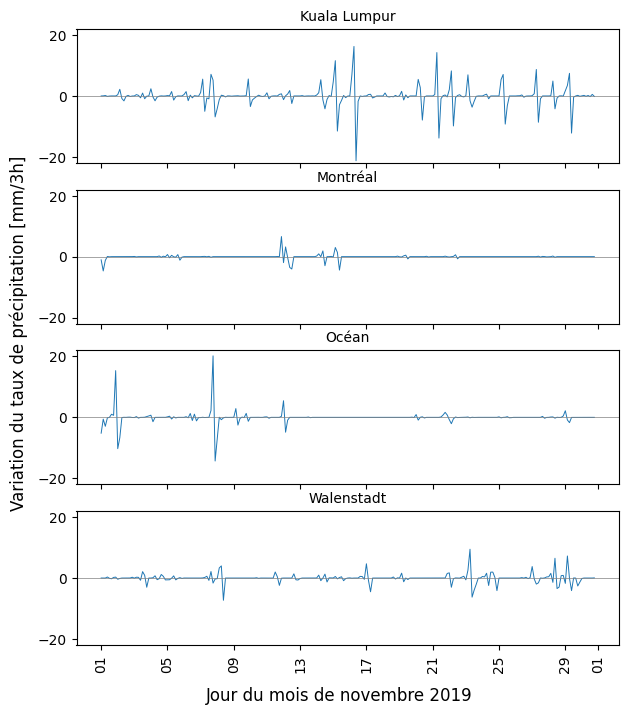

In [4]:
# kuala lumpur
kl_pcpts = kl_ds[var_name].values # type np.ndarray, (240,)
kl_var = np.diff(kl_pcpts) # (239,)
kl_time = kl_ds['time'].values[:-1]
# montréal
mtl_pcpts = mtl_ds[var_name].values
mtl_var = np.diff(mtl_pcpts)
mtl_time = mtl_ds['time'].values[:-1]
# océan
oce_pcpts = oce_ds[var_name].values
oce_var = np.diff(oce_pcpts)
oce_time = oce_ds['time'].values[:-1]
# walenstadt
wal_pcpts = wal_ds[var_name].values
wal_var = np.diff(wal_pcpts)
wal_time = wal_ds['time'].values[:-1]

# making the plot
fig, ax = plt.subplots(4, figsize=[7,8], sharex=True)
ax[0].plot(kl_time,kl_var, 'tab:blue', linewidth=0.7, alpha=1, label='Kuala Lumpur')
ax[0].axhline(y=0,linewidth=0.5, color = 'gray')
ax[0].set_title('Kuala Lumpur',fontsize='medium')
ax[1].plot(mtl_time,mtl_var, 'tab:blue', linewidth=0.7, label='Montréal')
ax[1].axhline(y=0,linewidth=0.5, color = 'gray')
ax[1].set_title('Montréal',fontsize='medium')
ax[2].plot(oce_time,oce_var, 'tab:blue', linewidth=0.7, label='Océan')
ax[2].axhline(y=0,linewidth=0.5, color = 'gray')
ax[2].set_title('Océan',fontsize='medium')
ax[3].plot(wal_time,wal_var, 'tab:blue', linewidth=0.7, label='Walenstadt')
ax[3].axhline(y=0,linewidth=0.5, color = 'gray')
ax[3].set_title('Walenstadt',fontsize='medium')

# -> noms des axes
fig.text(0.5, 0.04, 'Jour du mois de novembre 2019', ha='center', size='large')
fig.text(0.03, 0.5, 'Variation du taux de précipitation [mm/3h]', va='center', rotation='vertical', size='large')

# -> formatter les xticks
ax[-1].xaxis.set_major_formatter(mdates.DateFormatter('%d'))
plt.xticks(rotation=90)

# -> limites en y
ax[0].set_ylim([-22,22])
ax[1].set_ylim([-22,22])
ax[2].set_ylim([-22,22])
ax[3].set_ylim([-22,22])

plt.savefig('/Users/evecastonguay/Desktop/Labo/E_01/Figures/var_taux.png') #
plt.show()


#### 3a) Accumulation totale de précipitations

In [5]:
print(f"Accumulation totale [mm] de précipitations en novembre 2019 pour Kuala Lumpur: {kl_pcpts.sum():.2f}")
print(f"Accumulation totale [mm] de précipitations en novembre 2019 pour Montréal: {mtl_pcpts.sum():.2f}")
print(f"Accumulation totale [mm] de précipitations en novembre 2019 dans l'océan: {oce_pcpts.sum():.2f}")
print(f"Accumulation totale [mm] de précipitations en novembre 2019 pour Walenstadt: {wal_pcpts.sum():.2f}")

Accumulation totale [mm] de précipitations en novembre 2019 pour Kuala Lumpur: 277.08
Accumulation totale [mm] de précipitations en novembre 2019 pour Montréal: 67.31
Accumulation totale [mm] de précipitations en novembre 2019 dans l'océan: 114.87
Accumulation totale [mm] de précipitations en novembre 2019 pour Walenstadt: 167.65


#### 3b) Nombre de mesures avec un taux supérieur à 0mm/3h & fraction du temps qu'il pleut

In [6]:
kl_jours_pluie = np.sum(kl_pcpts > 0)
mtl_jours_pluie = np.sum(mtl_pcpts > 0)
oce_jours_pluie = np.sum(oce_pcpts > 0)
wal_jours_pluie = np.sum(wal_pcpts > 0)
print(f"Nombre de mesures avec un taux supérieur à 0mm/3h pour Kuala Lumpur: {kl_jours_pluie}")
print(f"Nombre de mesures avec un taux supérieur à 0mm/3h pour Montréal: {mtl_jours_pluie}")
print(f"Nombre de mesures avec un taux supérieur à 0mm/3h dans l'océan: {oce_jours_pluie}")
print(f"Nombre de mesures avec un taux supérieur à 0mm/3h pour Walenstadt: {wal_jours_pluie}")
kl_ftp = kl_jours_pluie/240
mtl_ftp = mtl_jours_pluie/240
oce_ftp = oce_jours_pluie/240
wal_ftp = wal_jours_pluie/240
print(f"F.t.p. pour Kuala Lumpur: {kl_ftp:.2f}")
print(f"f.t.p. pour Montréal: {mtl_ftp:.2f}")
print(f"F.t.p. en mer de Chine: {oce_ftp:.2f}")
print(f"F.t.p. pour Walenstadt: {wal_ftp:.2f}")

Nombre de mesures avec un taux supérieur à 0mm/3h pour Kuala Lumpur: 167
Nombre de mesures avec un taux supérieur à 0mm/3h pour Montréal: 64
Nombre de mesures avec un taux supérieur à 0mm/3h dans l'océan: 97
Nombre de mesures avec un taux supérieur à 0mm/3h pour Walenstadt: 135
F.t.p. pour Kuala Lumpur: 0.70
f.t.p. pour Montréal: 0.27
F.t.p. en mer de Chine: 0.40
F.t.p. pour Walenstadt: 0.56


#### 3c) Précipitation moyenne & intensité de pcpt moyenne

In [7]:
kl_pcpts_moy = kl_pcpts.mean()
kl_pcpts_int = kl_pcpts[kl_pcpts>0].mean()
print(f"Moyennes de précipitation et d'intensité de précipitation [mm/3h] pour Kuala Lumpur: {kl_pcpts_moy:.2f} et {kl_pcpts_int:.2f}")
mtl_pcpts_moy = mtl_pcpts.mean()
mtl_pcpts_int = mtl_pcpts[mtl_pcpts>0].mean()
print(f"Moyennes de précipitation et d'intensité de précipitation [mm/3h] pour Montréal: {mtl_pcpts_moy:.2f} et {mtl_pcpts_int:.2f}")
oce_pcpts_moy = oce_pcpts.mean()
oce_pcpts_int = oce_pcpts[oce_pcpts>0].mean()
print(f"Moyennes de précipitation et d'intensité de précipitation [mm/3h] pour la mer de Chine: {oce_pcpts_moy:.2f} et {oce_pcpts_int:.2f}")
wal_pcpts_moy = wal_pcpts.mean()
wal_pcpts_int = wal_pcpts[wal_pcpts>0].mean()
print(f"Moyennes de précipitation et d'intensité de précipitation [mm/3h] pour Walenstadt: {wal_pcpts_moy:.2f} et {wal_pcpts_int:.2f}")

Moyennes de précipitation et d'intensité de précipitation [mm/3h] pour Kuala Lumpur: 1.15 et 1.66
Moyennes de précipitation et d'intensité de précipitation [mm/3h] pour Montréal: 0.28 et 1.05
Moyennes de précipitation et d'intensité de précipitation [mm/3h] pour la mer de Chine: 0.48 et 1.18
Moyennes de précipitation et d'intensité de précipitation [mm/3h] pour Walenstadt: 0.70 et 1.24


#### 3d) Durée maximale des évènements de précipitation

In [8]:
# kl
zero_one_vector = kl_pcpts > 0
counts = []
n = 0
for i in zero_one_vector:
    if i==0:
        counts.append(n)
        n = 0
    if i==1:
        n+=1
print(f"Durée maximale des évènements de précipitation pour Kuala Lumpur: {max(counts)*3} heures")
# mtl
zero_one_vector = mtl_pcpts > 0
counts = []
n = 0
for i in zero_one_vector:
    if i==0:
        counts.append(n)
        n = 0
    if i==1:
        n+=1
print(f"Durée maximale des évènements de précipitation pour Montréal: {max(counts)*3} heures")
# oce
zero_one_vector = oce_pcpts > 0
counts = []
n = 0
for i in zero_one_vector:
    if i==0:
        counts.append(n)
        n = 0
    if i==1:
        n+=1
print(f"Durée maximale des évènements de précipitation pour la mer de Chine: {max(counts)*3} heures")
# wal
zero_one_vector = wal_pcpts > 0
counts = []
n = 0
for i in zero_one_vector:
    if i==0:
        counts.append(n)
        n = 0
    if i==1:
        n+=1
print(f"Durée maximale des évènements de précipitation pour Walenstadt: {max(counts)*3} heures")

Durée maximale des évènements de précipitation pour Kuala Lumpur: 45 heures
Durée maximale des évènements de précipitation pour Montréal: 33 heures
Durée maximale des évènements de précipitation pour la mer de Chine: 30 heures
Durée maximale des évènements de précipitation pour Walenstadt: 87 heures


#### 3e) Valeur maximale du taux de précipitation

In [9]:
print(f"Valeur maximale du taux de précipitation [mm/3h] pour Kuala Lumpur: {max(kl_pcpts):.2f}")
print(f"Valeur maximale du taux de précipitation [mm/3h] pour Montréal: {max(mtl_pcpts):.2f}")
print(f"Valeur maximale du taux de précipitation [mm/3h] pour la mer de Chine: {max(oce_pcpts):.2f}")
print(f"Valeur maximale du taux de précipitation [mm/3h] pour Walenstadt: {max(wal_pcpts):.2f}")

Valeur maximale du taux de précipitation [mm/3h] pour Kuala Lumpur: 23.25
Valeur maximale du taux de précipitation [mm/3h] pour Montréal: 7.89
Valeur maximale du taux de précipitation [mm/3h] pour la mer de Chine: 22.46
Valeur maximale du taux de précipitation [mm/3h] pour Walenstadt: 12.30


#### 3f) Points de grille supplémentaires à 50 km du point original

In [10]:
place = ["kl","mtl","oce","wal"] #

for p in place:
    # créer les coordonnées des 4 points à 50 km (0.45°) du point central
    globals()[f"{p}_1_lon"] = globals()[f"{p}_lon"]
    globals()[f"{p}_1_lat"] = globals()[f"{p}_lat"]+0.45
    globals()[f"{p}_2_lon"] = globals()[f"{p}_lon"]
    globals()[f"{p}_2_lat"] = globals()[f"{p}_lat"]-0.45
    globals()[f"{p}_3_lon"] = globals()[f"{p}_lon"]-0.45
    globals()[f"{p}_3_lat"] = globals()[f"{p}_lat"]
    globals()[f"{p}_4_lon"] = globals()[f"{p}_lon"]+0.45
    globals()[f"{p}_4_lat"] = globals()[f"{p}_lat"]

    for i in range(1,5):
        # créer un datastore contenant uniquement les valeurs de variable pour la coordonnée choisie
        globals()[f"{p}_{i}_ds"] = ds.sel(lon=globals()[f"{p}_{i}_lon"], lat=globals()[f"{p}_{i}_lat"], method='nearest')

        # valeurs (240) de précipitation pour la coordonnée choisie
        globals()[f"{p}_{i}_pcpts"] = globals()[f"{p}_{i}_ds"][var_name].values
        if  globals()[f"{p}_{i}_pcpts"].shape != (240,):
            raise ValueError(f"Le format attendu est (240,)")

        # redimensionner
        globals()[f"{p}_{i}_pcpts"] = globals()[f"{p}_{i}_pcpts"].reshape(1,240)

    # créer une matrice par endroit (5, 240). les lignes représentent les différentes coordonnées et les colonnes sont les observations
    globals()[f"{p}_pcpts_matrix"] = globals()[f"{p}_pcpts"].reshape(1,240)
    for i in range(1, 5):
        globals()[f"{p}_pcpts_matrix"] = np.append(globals()[f"{p}_pcpts_matrix"],globals()[f"{p}_{i}_pcpts"],axis=0)

    # calculer la corrélation
    globals()[f"{p}_corr_matrix"] = np.corrcoef(globals()[f"{p}_pcpts_matrix"])

    print(f'Corrélation entre la série temporelle de {p} et son point à 50 km au nord: {globals()[f"{p}_corr_matrix"][1,0]:.2f}')
    print(f'Corrélation entre la série temporelle de {p} et son point à 50 km au sud: {globals()[f"{p}_corr_matrix"][2, 0]:.2f}')
    print(f'Corrélation entre la série temporelle de {p} et son point à 50 km à l\'ouest: {globals()[f"{p}_corr_matrix"][3, 0]:.2f}')
    print(f'Corrélation entre la série temporelle de {p} et son point à 50 km à l\'est: {globals()[f"{p}_corr_matrix"][4, 0]:.2f}')
    mean = round(np.mean([globals()[f"{p}_corr_matrix"][1,0],globals()[f"{p}_corr_matrix"][2, 0],globals()[f"{p}_corr_matrix"][3, 0],globals()[f"{p}_corr_matrix"][4, 0]]),2)
    print(f'La corrélation temporelle moyenne entre les quatre séries et la série originale est {mean}')


Corrélation entre la série temporelle de kl et son point à 50 km au nord: 0.54
Corrélation entre la série temporelle de kl et son point à 50 km au sud: 0.50
Corrélation entre la série temporelle de kl et son point à 50 km à l'ouest: 0.23
Corrélation entre la série temporelle de kl et son point à 50 km à l'est: 0.25
La corrélation temporelle moyenne entre les quatre séries et la série originale est 0.38
Corrélation entre la série temporelle de mtl et son point à 50 km au nord: 0.85
Corrélation entre la série temporelle de mtl et son point à 50 km au sud: 0.80
Corrélation entre la série temporelle de mtl et son point à 50 km à l'ouest: 0.61
Corrélation entre la série temporelle de mtl et son point à 50 km à l'est: 0.87
La corrélation temporelle moyenne entre les quatre séries et la série originale est 0.78
Corrélation entre la série temporelle de oce et son point à 50 km au nord: 0.43
Corrélation entre la série temporelle de oce et son point à 50 km au sud: 0.68
Corrélation entre la séri

#### 3f) Points de grille supplémentaires à 50 km du point original - scatter plot

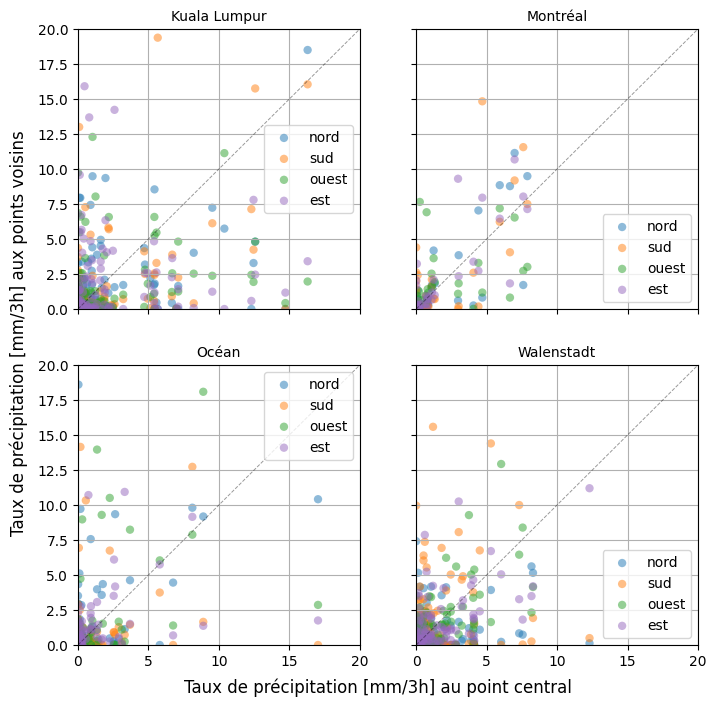

In [11]:
# données pour les graphiques
color = ['tab:blue', 'tab:orange', 'tab:green', 'tab:purple']
label = ['nord', 'sud', 'ouest', 'est']

# données pour créer la droite x=y
x = [0,10,20]
y = [0,10,20]

fig, ax = plt.subplots(2,2,sharex=True, sharey=True, figsize=(8, 8))

# Kuala Lumpur
# -> scatter plot
for i in range(1,5):
    ax[0,0].scatter(kl_pcpts, globals()[f"kl_{i}_pcpts"], c=color[i-1], label=label[i-1], alpha=0.5, edgecolors='none')
# -> droite linéaire
ax[0,0].plot(x,y,linestyle='--',lw=0.7,color='k',alpha=0.4)
# -> titre
ax[0,0].set_title('Kuala Lumpur',fontsize='medium')

# Montréal
# -> scatter plot
for i in range(1,5):
    ax[0,1].scatter(mtl_pcpts, globals()[f"mtl_{i}_pcpts"], c=color[i-1], label=label[i-1], alpha=0.5, edgecolors='none')
# -> droite linéaire
ax[0,1].plot(x,y,linestyle='--',lw=0.7,color='k',alpha=0.4)
# -> titre
ax[0,1].set_title('Montréal',fontsize='medium')

# Océan
# -> scatter plot
for i in range(1,5):
    ax[1,0].scatter(oce_pcpts, globals()[f"oce_{i}_pcpts"], c=color[i-1], label=label[i-1], alpha=0.5, edgecolors='none')
# -> droite linéaire
ax[1,0].plot(x,y,linestyle='--',lw=0.7,color='k',alpha=0.4)
# -> titre
ax[1,0].set_title('Océan',fontsize='medium')

# Walenstadt
# -> scatter plot
for i in range(1,5):
    ax[1,1].scatter(wal_pcpts, globals()[f"wal_{i}_pcpts"], c=color[i-1], label=label[i-1], alpha=0.5, edgecolors='none')
# -> droite linéaire
ax[1,1].plot(x,y,linestyle='--',lw=0.7,color='k',alpha=0.4)
# -> titre
ax[1,1].set_title('Walenstadt',fontsize='medium')

# limites, grille et légende des graphiques
for ax in ax.ravel():
    ax.set_xlim(0, 20)
    ax.set_ylim(0, 20)
    ax.legend()
    ax.grid(True)

# noms des axes
fig.text(0.5, 0.05, 'Taux de précipitation [mm/3h] au point central', ha='center', size='large')
fig.text(0.04, 0.5, 'Taux de précipitation [mm/3h] aux points voisins', va='center', rotation='vertical', size='large')

plt.savefig('/Users/evecastonguay/Desktop/Labo/E_01/Figures/scatter.png')
plt.show()


#### 4) Cycle journalier de précipitation

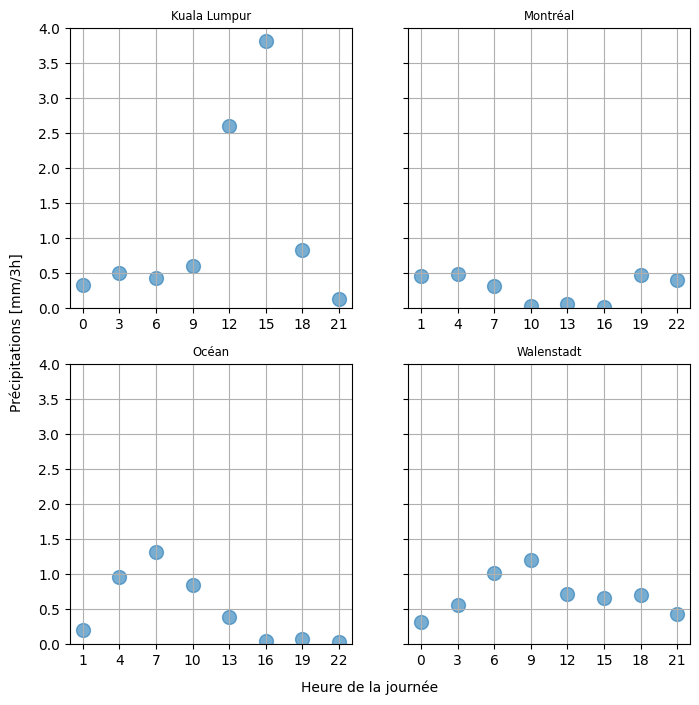

In [12]:
# note pour Montréal - malgré changement d'heure le 3 novembre à 2 am, assumé heure standard d'hiver pour ne pas créer un double dans les données au moment du changement d'heure

# -> calcul de l'ajustement à l'heure UTC pour chaque ville
kl_local = kl_lon/15
mtl_local = mtl_lon/15
oce_local = oce_lon/15
wal_local = wal_lon/15

# -> boucle pour condenser le code
place = ["kl","mtl","oce","wal"] # "kl","mtl","oce","wal"

fig, ax = plt.subplots(2,2,sharey=True,figsize=(8, 8))

for p in place:
    # -> conversion du décalage horaire (_local) en nombre de secondes de décalage
    globals()[f"{p}_s"] = int(globals()[f"{p}_local"] * 60 * 60)

    # -> faire le changement d'heure
    globals()[f"{p}_time"] = globals()[f"{p}_ds"]['time'].values  # class np.datetime64, (240,), format: '2019-11-30T21:00:00.000000000'
    globals()[f"{p}_time"] = globals()[f"{p}_time"] +np.timedelta64(globals()[f"{p}_s"], 's')

    '''les heures locales de chaque ville sont encodées dans:
    kl_time
    mtl_time
    oce_time
    wal_time
    (type = numpy.ndarray à l'intérieur du duquel il y a des numpy.datetime64)'''

    # -> listes contenant les différentes heures de mesure dans une journée & les indices associés aux prises de mesure pour chaque heure
    heures = np.array([],dtype=int)
    indices = np.array([],dtype=int)
    mean_pcpts = np.array([])

    for i, val in enumerate(globals()[f"{p}_time"]):
        t = pd.Timestamp(val) # changer le format de l'heure (timestamp=pandas, datetime64=numpy)
        h = t.hour
        heures = np.append(heures, h)
        indices = np.append(indices, i)

    heures_uniques = np.unique(heures)
    dict = {h_u: indices[heures == h_u] for h_u in heures_uniques}

    # -> trouver la moyenne des précipitations à chaque heure
    for h_u in heures_uniques:
        mean_pcpts = np.append(mean_pcpts, globals()[f"{p}_pcpts"][dict[h_u]].mean())

    # -> plot
    if p == 'kl':
        ax[0,0].scatter(heures_uniques, mean_pcpts, c='tab:blue', s=100, alpha=0.6)
        ax[0,0].set(xticks=heures_uniques)
        ax[0,0].set_title('Kuala Lumpur',fontsize='small')

    elif p == 'mtl':
        ax[0,1].scatter(heures_uniques, mean_pcpts, c='tab:blue', s=100, alpha=0.6)
        ax[0,1].set(xticks=heures_uniques)
        ax[0,1].set_title('Montréal',fontsize='small')

    elif p == 'oce':
        ax[1,0].scatter(heures_uniques, mean_pcpts, c='tab:blue', s=100, alpha=0.6)
        ax[1,0].set(xticks=heures_uniques)
        ax[1,0].set_title('Océan',fontsize='small')

    elif p == 'wal':
        ax[1,1].scatter(heures_uniques, mean_pcpts, c='tab:blue', s=100, alpha=0.6)
        ax[1,1].set(xticks=heures_uniques)
        ax[1,1].set_title('Walenstadt',fontsize='small')

# limites, grille et légende des graphiques
for ax in ax.ravel():
    ax.set_ylim(0, 4)
    yticks=np.arange(0, 4, 0.5)
    ax.grid(True)

# noms des axes
fig.text(0.5, 0.05, 'Heure de la journée', ha='center')
fig.text(0.05, 0.5, 'Précipitations [mm/3h]', va='center', rotation='vertical')

plt.savefig('/Users/evecastonguay/Desktop/Labo/E_01/Figures/hour_mean.png')
plt.show()